# ITER Window test-bed T-Resonator

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import skrf as rf
from skrf.media import Coaxial

# Importing the DUT S-parameters

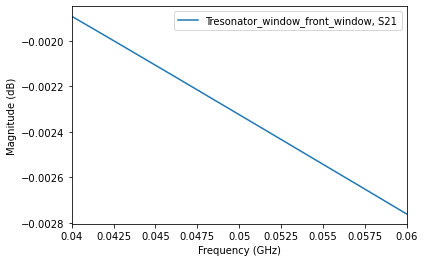

In [3]:
DUT0=rf.Network('S-parameters/Tresonator_window_front_window.s2p')
DUT0.plot_s_db(m=1, n=0)

# Building the T-resonator

In [4]:
class Tresonator():
    def __init__(self, L_CEA=100, L_DUT=200, f=None):
        self.Z_short_DUT = 1e-5
        self.Z_short_CEA = 2e-2
        self.L_CEA = L_CEA
        self.L_DUT = L_DUT

        self.DUT = rf.Network('S-parameters/Tresonator_window_front_window.s2p')

        # the frequency range is the one of the DUT
        if f:
            self.frequency = rf.Frequency(f, f, npoints=1, unit='MHz')
        else:    
            self.frequency = rf.Frequency(start=50, stop=60, npoints=200, unit='MHz')
        self.DUT = self.DUT.interpolate(self.frequency)

        # electrical conductivities
        self.conductivity_SS = 1/69e-8 # 1.45e6 in Wikipedia
        self.conductivity_Cu = 1/1.682e-8 # 5.8e7 # Annealed copper.  5.96e7 for pure Cu in Wikipedia
        self.conductivity_Cu = 34578645  # Copper 200deg 
        self.conductivity_Ag = 1/1.59e-8 #6.3e7 # Wikipedia
        self.conductivity_Al = 1/2.65e-8 #3.8e7 # Wikipedia

    @property
    def circuit(self):
        Tee = Coaxial(frequency=self.frequency, Dint=0.140,  Dout=0.230, epsilon_r=1, sigma=self.conductivity_Ag).tee(name='Tee')

        # Equivalent DUT
#         self.DUT = Coaxial(frequency=self.frequency, Dint=0.140, Dout=0.196, epsilon_r=1, sigma=self.conductivity_Cu).line()
        
        # CEA Branch
        C0 = Coaxial(frequency=self.frequency, Dint=0.140,  Dout=0.230, epsilon_r=1, sigma=self.conductivity_Ag).line(200, unit='mm', name='C0')  # T (1/2)
        C1 = Coaxial(frequency=self.frequency, Dint=0.130,  Dout=0.294, epsilon_r=1, sigma=self.conductivity_Ag).line(180, unit='mm', name='C1')
        C2 = Coaxial(frequency=self.frequency, Dint=0.140,  Dout=0.230, epsilon_r=1, sigma=self.conductivity_Al).line(2000, unit='mm', name='C2')
        _C3 = Coaxial(frequency=self.frequency, Dint=0.140,  Dout=0.230, epsilon_r=1, sigma=self.conductivity_Al)
        C3 = _C3.line(self.L_CEA, unit='mm', name='C3')

        # DUT Branch
        D0 = Coaxial(frequency=self.frequency, Dint=0.140,  Dout=0.230, epsilon_r=1, sigma=self.conductivity_Ag).line(200, unit='mm', name='D0') # T (1/2)
        D1 = Coaxial(frequency=self.frequency, Dint=0.140, Dout=0.230, epsilon_r=1, sigma=self.conductivity_Ag).line(100, unit='mm', name='D1')
        LB1 = Coaxial(frequency=self.frequency, Dint=0.140, Dout=0.410, epsilon_r=1, sigma=self.conductivity_Cu).line(239, unit='mm', name='LB1')
        LB2 = Coaxial(frequency=self.frequency, Dint=0.140, Dout=0.230, epsilon_r=1, sigma=self.conductivity_Cu).line(1224, unit='mm', name='LB2')
        LB3 = Coaxial(frequency=self.frequency, Dint=0.140, Dout=0.230, epsilon_r=1, sigma=self.conductivity_Cu).line(200, unit='mm', name='LB3')
        _LB5 = Coaxial(frequency=self.frequency, Dint=0.140, Dout=0.230, epsilon_r=1, sigma=self.conductivity_Cu)
        LB5 = _LB5.line(self.L_DUT, unit='mm', name='LB5')

        # T-Resonator Input port
        port1 = rf.Circuit.Port(frequency=self.frequency, z0=30, name='port1')
        # Short circuits
        resistor_dut = _LB5.resistor(self.Z_short_DUT, name='short_dut')
        resistor_cea = _C3.resistor(self.Z_short_CEA, name='short_cea')
        gnd_dut = rf.Circuit.Ground(frequency=self.frequency, z0=_LB5.z0[0], name='gnd_dut')
        gnd_cea = rf.Circuit.Ground(frequency=self.frequency, z0=_C3.z0[0], name='gnd_cea')

        cnx = [
            # T-junction
            [(port1, 0), (Tee, 0)], 
            [(Tee, 1), (C0, 0)], [(Tee, 2), (D0, 0)],
            # DUT Branch
            [(D0, 1), (D1, 0)],
            [(D1, 1), (LB1, 0)],
            [(LB1, 1), (LB2, 0)],
            [(LB2, 1), (LB3, 0)],
            [(LB3, 1), (self.DUT, 1)],
            [(self.DUT, 0), (LB5, 0)],
            [(LB5, 1), (resistor_dut, 0)],
            [(resistor_dut, 1), (gnd_dut, 0)],
            # CEA branch
            [(C0, 1), (C1, 0)],
            [(C1, 1), (C2, 0)],
            [(C2, 1), (C3, 0)],
            [(C3, 1), (resistor_cea, 0)],
            [(resistor_cea, 1), (gnd_cea, 0)],
        ]
        self._circuit = rf.Circuit(cnx)
        return self._circuit
    
    @property
    def network(self):
        return self.circuit.network

def plot_s11(L_CEA=100, L_DUT=200):
    fig, ax = plt.subplots()
    Tresonator(L_CEA, L_DUT).network.plot_s_db(ax=ax)
    ax.set_ylim(-30,1)


In [5]:
interact(plot_s11, 
         L_CEA=widgets.FloatSlider(min=1, max=500, step=1, value=100), 
         L_DUT=widgets.FloatSlider(min=1, max=500, step=1, value=200))

interactive(children=(FloatSlider(value=100.0, description='L_CEA', max=500.0, min=1.0, step=1.0), FloatSlider…

<function __main__.plot_s11(L_CEA=100, L_DUT=200)>

In [6]:
L_CEAs = np.linspace(0, 300, 50)
fs = np.linspace(50, 60, 50)

LL_CEA, LL_fs = np.meshgrid(L_CEAs, fs)

In [7]:
def S11_f_match(d_CEA, f):
    _res = tres(L_CEA=d_CEA, f=f)
    
    return np.squeeze(_res.s_db[0])

vfunc = np.vectorize(S11_f_match)

In [8]:
S11 = vfunc(LL_CEA, LL_fs)

NameError: name 'tres' is not defined

In [ ]:
fig,ax=plt.subplots()
c=ax.pcolor(LL_CEA, fs, S11, cmap='Greens_r')
fig.colorbar(c)
# ax.axvline(d_DUT_opt*1e3, ls='--')
# ax.axhline(d_CEA_opt*1e3, ls='--')

ax.set_xlabel('L CEA [mm]')
ax.set_ylabel('f [MHz]')
ax.set_title('s11 [dB]')